In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt
from scipy.signal import savgol_filter

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


       0       1       2    3    4    5       6     7      8      9
0  10476  0.2642 -4658.2  0.0  0.0  0.0  0.2795  A1YA  80466  80000
1  10476  0.2626 -4657.2  0.0  0.0  0.0  0.2778  A1YA  80566  80000
2  10476  0.2389 -4631.2  0.0  0.0  0.0  0.2527  A1YA  83166  80000
3  10476  0.2427 -4629.2  0.0  0.0  0.0  0.2568  A1YA  90266  80000
4  10476  0.2293 -4609.2  0.0  0.0  0.0  0.2426  A1YA  92266  80000


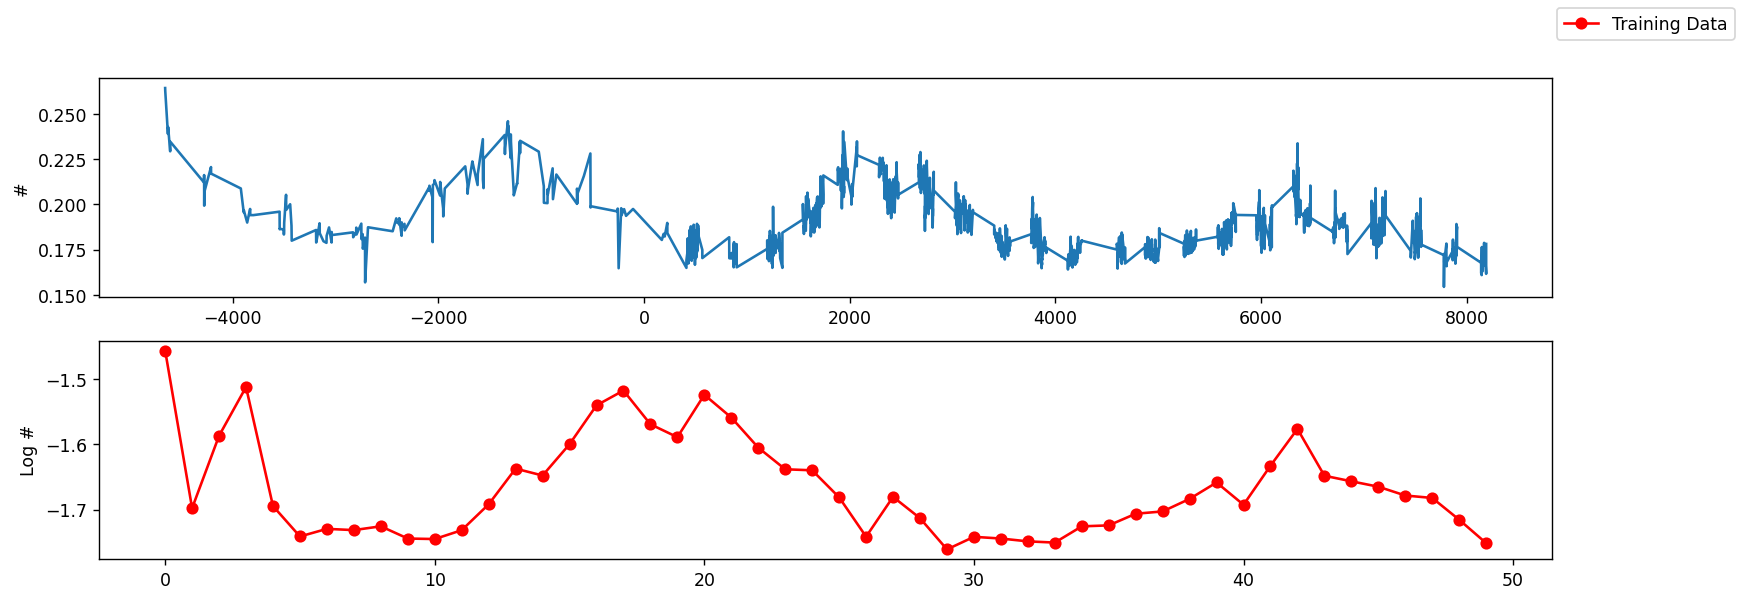

In [19]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd010476.csv', header=None, delimiter='\s+') 
X = df[2]
y = df[1]

print(df.head())

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::40]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])
#ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].plot(X, y)
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
fig.legend();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, Length Scale 2, Length Scale 1, period, amplitude]


/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after

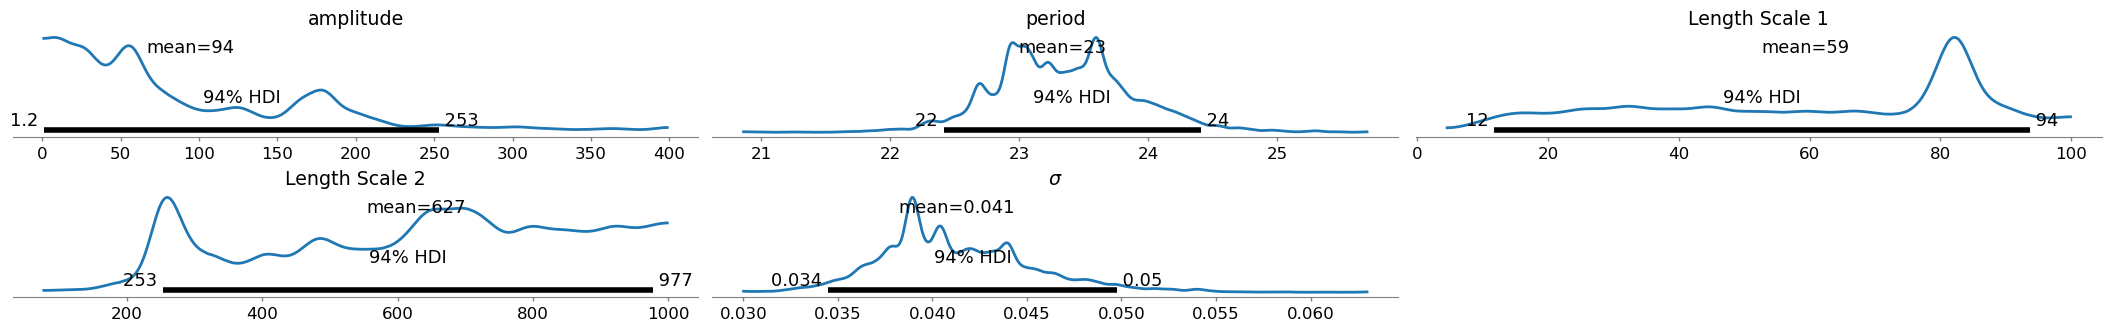

In [3]:
# Define the Gaussian Process
with pm.Model() as model:

    # Define the phase of the sinusoidal mean
    #phase = pm.Normal('phase', 1.73, 0.5) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Uniform('amplitude', 0, 400) 
     
    # Define the offset of the sinusoidal mean
    #offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 0, 1000)
    
    # Define the `length scale 1' of the periodic kernel
    length_scale1 = pm.Uniform('Length Scale 1', 0, 100)  
    
    # Define the `length_scale 2' of the squared-exponential kernel 
    length_scale2 = pm.Uniform('Length Scale 2', 0, 1000)
    
    # Define the `Standard deviation' 
    sigma = pm.Uniform('$\sigma$', 0.0, 1)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = amplitude * cov_SE * cov_periodic
    
    #sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=np.linspace(0,len(training_data)).reshape(-1,1), y=training_data, noise=sigma)

    tr = pm.sample(return_inferencedata=True)

az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);

In [6]:
X_new = np.linspace(0, len(training_data), 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])
    
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(df[2], color="black", label="All Data")
plt.xlabel("")
plt.ylabel('')
plt.xlim(0,len(training_data))
#plt.ylim(0,300)
plt.legend();

ValueError: Variable name f_new already exists.

In [ ]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd013421.csv', header=None, delimiter='  ') 
X = df[0]
y = df[2]

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::40]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])
ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
fig.legend();

In [ ]:
# Define the Gaussian Process
with pm.Model() as model:

    # Define the phase of the sinusoidal mean
    #phase = pm.Normal('phase', 1.73, 0.5) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Uniform('amplitude', 0, 400) 
     
    # Define the offset of the sinusoidal mean
    #offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 0, 1000)
    
    # Define the `length scale 1' of the periodic kernel
    length_scale1 = pm.Uniform('Length Scale 1', 0, 1000)  
    
    # Define the `length_scale 2' of the squared-exponential kernel 
    length_scale2 = pm.Uniform('Length Scale 2', 0, 10000)
    
    # Define the `Standard deviation' 
    sigma = pm.Uniform('$\sigma$', 0.0, 1)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = amplitude * cov_SE * cov_periodic 
    
    #sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=np.linspace(0,len(training_data)).reshape(-1,1), y=training_data, noise=sigma)

    tr = pm.sample(return_inferencedata=True)

az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);

In [ ]:
X_new = np.linspace(0, len(training_data), 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])
    
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(y, color="black", label="All Data")
plt.xlabel("")
plt.ylabel('')
plt.xlim(0,len(training_data))
#plt.ylim(0,300)
plt.legend();

In [ ]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd018256.csv', header=None, delimiter='  ') 
X = df[0]
y = df[2]

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::40]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])
ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
fig.legend();

In [ ]:
# Define the Gaussian Process
with pm.Model() as model:

    # Define the phase of the sinusoidal mean
    #phase = pm.Normal('phase', 1.73, 0.5) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Uniform('amplitude', 0, 400) 
     
    # Define the offset of the sinusoidal mean
    #offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 0, 1000)
    
    # Define the `length scale 1' of the periodic kernel
    length_scale1 = pm.Uniform('Length Scale 1', 0, 100)  
    
    # Define the `length_scale 2' of the squared-exponential kernel 
    length_scale2 = pm.Uniform('Length Scale 2', 0, 1000)
    
    # Define the `Standard deviation' 
    sigma = pm.Uniform('$\sigma$', 0.0, 1)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = amplitude * cov_SE * cov_periodic
    
    #sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=np.linspace(0,len(training_data)).reshape(-1,1), y=training_data, noise=sigma)

    tr = pm.sample(return_inferencedata=True)

az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);

In [ ]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd025998.csv', header=None, delimiter='  ') 
X = df[0]
y = df[2]

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::40]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])
ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
fig.legend();

In [ ]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd039587.csv', header=None, delimiter='  ') 
X = df[0]
y = df[2]

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::50]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])
ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
fig.legend();

In [ ]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd076572.csv', header=None, delimiter='  ') 
X = df[0]
y = df[2]

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::40]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])
ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
fig.legend();

In [10]:
df = pd.read_csv('../Data/Stellar Cycle Data/hd081809.csv', header=None, delimiter='  ') 
print(df.head())
X = df[0]
y = df[7]

window_length = int(101)  # the number of coefficients --> must be odd
poly_order = 2 # order of the polynomial used to fit the samples
color = 'tab:orange'
smoothed = savgol_filter(y, window_length, poly_order)

training_values =  smoothed[::30]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = np.log(training_values)  
# take logs to obtain positive definite values

fig, ax = plt.subplots(3, dpi=125, figsize=[15,5])
ax[0].plot(training_values, label='Training Values', marker='o')
ax[0].set_ylabel("#")
ax[1].plot(training_data, label='Training Data', color='red', marker='o')
ax[1].set_ylabel("Log #")
ax[1].set_xlabel('')
ax[2].plot(y)
fig.legend();

      0   1       2   3       4   5   6     7       8       9   \
0  81809 NaN  0.1872 NaN -4806.2 NaN NaN   0.0  0.0000  0.0000   
1  81809 NaN  0.1756 NaN -4805.2 NaN NaN   0.0  0.0000  0.0000   
2  81809 NaN  0.1795 NaN -4513.2 NaN NaN   0.0  0.0000  0.0000   
3  81809 NaN  0.2035 NaN -4484.2 NaN NaN   0.0  0.0000  0.0000   
4  81809 NaN  0.2000 NaN -4483.2 NaN NaN   0.0  0.0000  0.0000   

                          10  
0  0.1922 A1YA 030966 080000  
1  0.1803 A1YA 031066 080000  
2  0.1843 A1YA 122766 080000  
3  0.2090 A1YA 012567 080000  
4  0.2054 A1YA 012667 080000  


/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_79563/2332697439.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../Data/Stellar Cycle Data/hd081809.csv', header=None, delimiter='  ')


ValueError: could not convert string to float: '0.1486 C1YC 110280 122910'

In [ ]:
# Define the Gaussian Process
with pm.Model() as model:

    # Define the phase of the sinusoidal mean
    #phase = pm.Normal('phase', 1.73, 0.5) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Uniform('amplitude', 0, 400) 
     
    # Define the offset of the sinusoidal mean
    #offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 0, 1000)
    
    # Define the `length scale 1' of the periodic kernel
    length_scale1 = pm.Uniform('Length Scale 1', 0, 100)  
    
    # Define the `length_scale 2' of the squared-exponential kernel 
    length_scale2 = pm.Uniform('Length Scale 2', 0, 1000)
    
    # Define the `Standard deviation' 
    sigma = pm.Uniform('$\sigma$', 0.0, 1)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = amplitude * cov_SE * cov_periodic
    
    #sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=np.linspace(0,len(training_data)).reshape(-1,1), y=training_data, noise=sigma)

    tr = pm.sample(return_inferencedata=True)

az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);